In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba[:,1])]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [4]:
random_seed = 108
test_size = 0.2

In [5]:
orig_data = pd.read_csv('MASTER STEMI database 2010 - 2019.csv')

In [6]:
cols = [
    'Age',
    'Sex (0 = Male, 1=Female)',
    'Height',
    'Weight',
    'BMI',
    'Hypertension', 
    'Hypercholesterolaemia',
    'Smoking History( 2= current, 1 = ex smoke, 0 = never)', 
    'Diabetes',
    'Family History',
    'Previous stent',
    'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)',
    'TIMI flow pre', 
    'TIMI Flow post',
    'Rentrop Simplified',
    'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)',
    'No. of stent',
    'Length of stent',
    'CTO in remote vessel',
    'Pre-Hospital Arrest',
    'GP IIb/IIIa inhibitor', 
    'Inotrope during case', 
    'Starting HR',
    'Starting SBP',
    'Arrhythmia during case', 
    'IABP/ECMO',
    'Time from onset to angio (Hrs)'
]

orig_data['LVEF FINAL'] = orig_data['LVEF FINAL'].replace([-55,-99],np.NaN)

orig_data["lvef_abnormal"] = [np.NaN if np.isnan(x) else 1 if x < 40 else 0 for x in orig_data['LVEF FINAL']]

predictors = ["lvef_abnormal",'In-Hospital Mortality','ICU admission']

df = orig_data[cols + predictors]

In [7]:
df = df.replace([-55,-99],np.NaN)

for c in df.columns:
    df[c] = df[c].replace('', np.NaN)
    df[c] = df[c].replace('-', np.NaN)
    df[c] = df[c].replace('[a-zA-Z]+', np.NaN).astype(float)
    
df["Height"] = df["Height"].replace(0,np.NaN)
df["Age"] = df["Age"].where(df.Age.between(16, 105)) # remove ages less than 16 and greater than 105

df['Time from onset to angio (Hrs)'] = df['Time from onset to angio (Hrs)'].where(df['Time from onset to angio (Hrs)'] >= 0) 

In [8]:
df["log_length_stent"] = np.log(df['Length of stent'])
df["log_onset_to_angio"] = np.log(df['Time from onset to angio (Hrs)'])
df.drop(['Length of stent','Time from onset to angio (Hrs)'],axis = 1,inplace=True)

In [9]:
df_subset_index = {}
for p in predictors:
    df_subset_index[p] = df.index[df[p].notna()].tolist()

In [10]:
float_col = [
    'Age',
    'Height',
    'Weight',
    'BMI',
    #'Length of stent',
    'log_length_stent',
    'Starting HR',
    'Starting SBP',
    #'Time from onset to angio (Hrs)',
    'log_onset_to_angio',
    'No. of stent'
]
categorical_col = [c for c in df.columns if c not in float_col + predictors]

In [11]:
df_dummy =  pd.get_dummies(
        df,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [12]:
df_dummy.columns
df_dummy_cat_cols = [x for x in df_dummy.columns if x not in float_col + predictors]

In [13]:
from sklearn.model_selection import train_test_split

train,test = {},{}
for p in predictors:
    train[p],test[p]= train_test_split(df_subset_index[p], test_size=test_size, random_state=random_seed)


In [20]:
final_result_df = pd.read_csv("result/final_out.csv")

### Generate table 1

In [14]:
cont_describe = df[float_col].describe()

In [15]:
cont_describe = pd.concat([cont_describe,pd.DataFrame(df[float_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe.loc['NA_perc',:] = cont_describe.loc['NA',:]/df.shape[0]*100

In [16]:
cont_describe

,Age,Height,Weight,BMI,log_length_stent,Starting HR,Starting SBP,log_onset_to_angio,No. of stent
count,1863.000000,1786.000000,1849.000000,1762.000000,1714.000000,1851.000000,1846.000000,1657.000000,1863.000000
mean,64.897962,166.477245,78.994214,27.266533,3.287744,79.828201,122.682015,1.474596,1.160494
std,13.724473,38.441907,24.813583,4.804756,0.465309,19.898681,28.185260,1.041507,0.635933
min,24.076660,-99.000000,-99.000000,13.000000,1.791759,30.000000,34.000000,-1.149906,0.000000
25%,54.956879,165.000000,70.000000,24.000000,2.890372,66.000000,103.250000,0.684779,1.000000
50%,64.536619,172.000000,80.000000,27.000000,3.258097,78.000000,121.000000,1.252763,1.000000
75%,74.904860,178.000000,90.000000,30.000000,3.637586,92.000000,141.000000,2.153698,1.000000
max,102.915811,200.000000,172.000000,53.254438,4.718499,170.000000,231.000000,4.346399,5.000000
NA,0.000000,77.000000,14.000000,101.000000,149.000000,12.000000,17.000000,206.000000,0.000000
NA_perc,0.000000,4.133119,0.751476,5.421363,7.997853,0.644122,0.912507,11.057434,0.000000


In [37]:
cont_describe.to_csv("result/data/continuous_variable_summary.csv")

In [38]:
import re
for c in categorical_col+predictors:
    df_sub = pd.concat([
        df[c].value_counts(dropna=False),
        df[c].value_counts(dropna=False,normalize=True)*100,
    ]
    ,axis=1).sort_index()
    df_sub.to_csv("result/data/" + re.sub('[^A-Za-z0-9]+', '', c) + "_summary.csv")

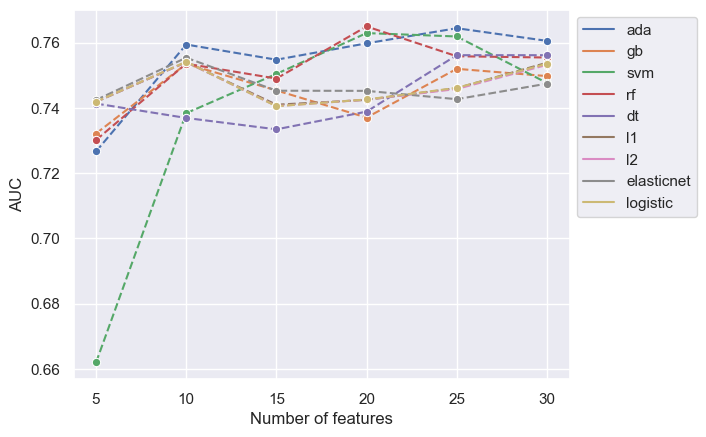

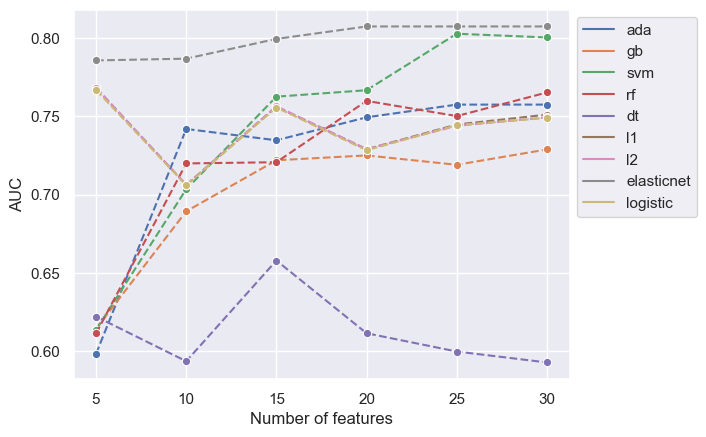

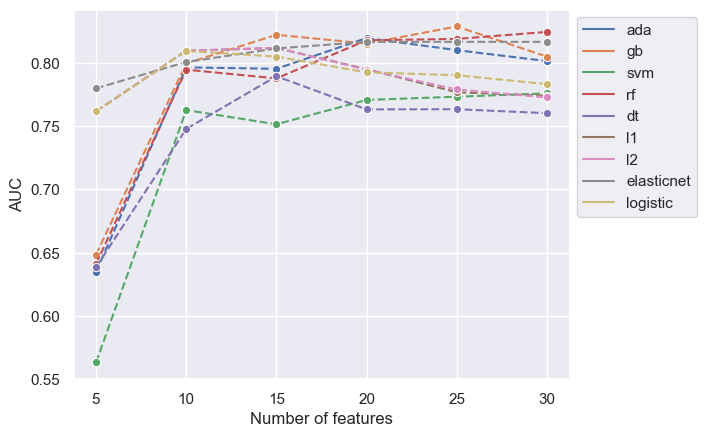

In [44]:

# generate AUC curves against n of features
for p in predictors:
    f,ax = plt.subplots()
    #for m in final_result_df["model"].unique():
    df_sub = final_result_df.query("outcome == @p")
    ax = sns.lineplot(df_sub,x = 'n_feature',y='auc',hue='model',ax=ax,marker='o',linestyle ='--')
    ax.set_xlabel('Number of features')
    ax.set_ylabel('AUC')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig("paper_figure/n_feature_plot_" + p +".png",bbox_inches="tight")

## Probability calibration

In [20]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
import os
dir = 'C:\\Users\\Harrison Nguyen\\Documents\\CardiacCovidModel\\stemi\\'

In [16]:
model_dict = {
    'In-Hospital Mortality':"model\\elasticnet_feature_selection5_oversample_ICU admission.pickle",
    'lvef_abnormal':"model\\elasticnet_feature_selection5_oversample_lvef_abnormal.pickle",
    'ICU admission':"model\\elasticnet_feature_selection5_oversample_ICU admission.pickle"
}

D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarn

No calibration: 0.215
With isotonic calibration: 0.061
With sigmoid calibration: 0.061
No calibration: 0.187
With isotonic calibration: 0.151
With sigmoid calibration: 0.152
No calibration: 0.204
With isotonic calibration: 0.087
With sigmoid calibration: 0.090


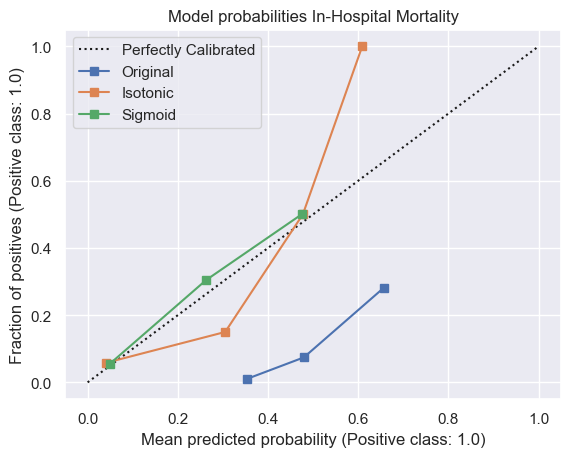

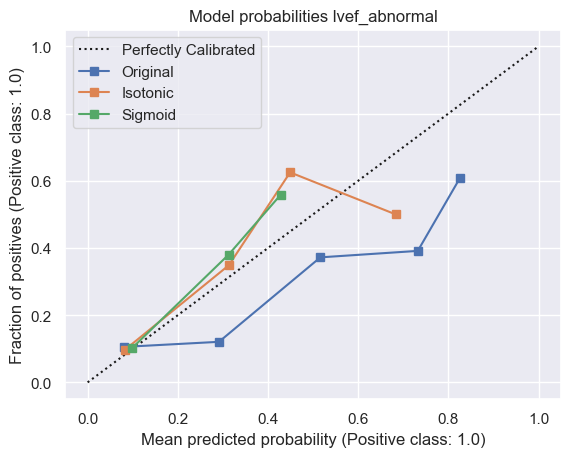

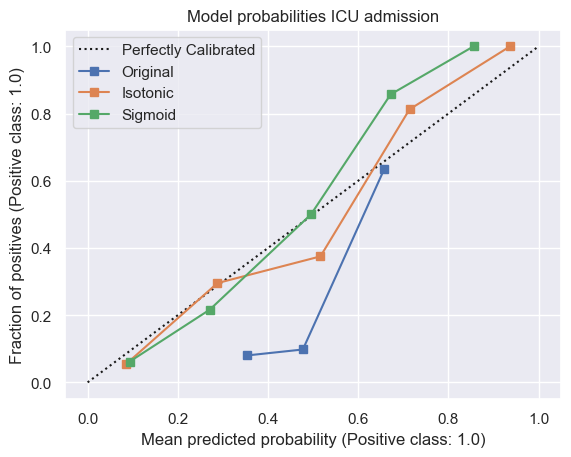

In [85]:
model_name = 'elasticnet_feature_selection5_oversample'
for k,v in model_dict.items():
    p = k
    pipe = joblib.load(os.path.join(dir,v))
    y_train = df_dummy.loc[train[p],p]
    X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)
    
    clf_isotonic = CalibratedClassifierCV(pipe, cv=5, method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    
    joblib.dump(clf_isotonic,"model/" + model_name + "_" + k + "_isotonic_calibration" +".pickle")

    clf_sigmoid = CalibratedClassifierCV(pipe, cv=5, method="sigmoid")
    clf_sigmoid.fit(X_train, y_train)
    joblib.dump(clf_sigmoid,"model/" + model_name + "_" + k + "_sigmoid_calibration" +".pickle")


    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)

    prob_pos_clf = pipe.predict_proba(X_test)[:, 1]
    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)

    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    
    f,ax = plt.subplots()
    CalibrationDisplay.from_estimator(pipe, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_isotonic, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_sigmoid, X_test, y_test,ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Perfectly Calibrated","Original","Isotonic","Sigmoid"])
    ax.set_title("Model probabilities " + p)
    
    plt.savefig("paper_figure/calibration_plot_" + p +".png",bbox_inches="tight")

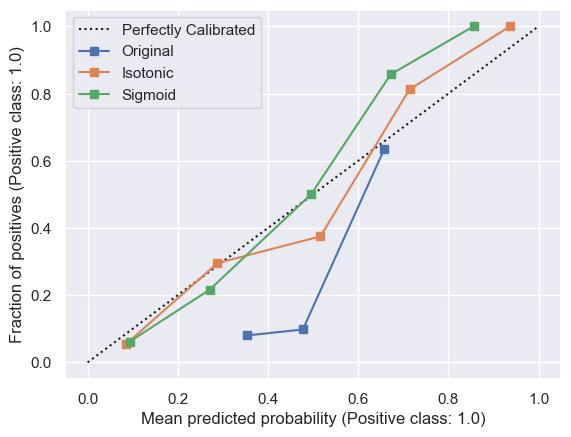

In [29]:
### double check calibration doesn't change auc metric
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
model_name = 'elasticnet_feature_selection5_oversample'
for k,v in model_dict.items():
    print(k)
    p = k
    pipe = joblib.load(os.path.join(dir,v))
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    
    yhat_proba = pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
          
    iso_pipe = joblib.load("model/" + model_name + "_" + k + "_isotonic_calibration" +".pickle")
    yhat_proba = iso_pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
    

    sig_pipe = joblib.load("model/" + model_name + "_" + k + "_sigmoid_calibration" +".pickle")
    yhat_proba = sig_pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

In-Hospital Mortality
0.7554865424430641
0.793944099378882
0.7844720496894411
lvef_abnormal
0.7424025974025974
0.758896103896104
0.7611255411255412
ICU admission
0.7800024342745863
0.8140518500486855
0.807935735150925


### evaluate calbirated model

In [21]:
test_df_calibrated = pd.DataFrame.from_dict(
    {'model': [],
     'calibration':[],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

for k,v in model_dict.items():
    p = k
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    for c in ["isotonic","sigmoid","none"]:

        model_name = 'elasticnet_feature_selection5_oversample'
        if c == "none":
            test_pipe = joblib.load("model/{}_{}.pickle".format(model_name,p))
        else:
            test_pipe = joblib.load("model/{}_{}_{}_calibration.pickle".format(model_name,p,c))
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        #print(test_pipe.predict_proba(X_test)[:,1])
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name
        test_result_df["calibration"] = c
        test_result_df["brier_score"] = brier_score_loss(y_test, test_pipe.predict_proba(X_test)[:,1])

        test_df_calibrated = pd.concat([test_df_calibrated,test_result_df],ignore_index=True)
test_df_calibrated.to_csv("result/final_outcome_calibrated.csv")

In [22]:
test_df_calibrated

,model,calibration,accuracy,precision,recall,f1_score,auc,outcome,brier_score
0,elasticnet_feature_selection5_oversample,isotonic,0.930295,0.750000,0.107143,0.187500,0.793944,In-Hospital Mortality,0.060689
1,elasticnet_feature_selection5_oversample,sigmoid,0.922252,0.000000,0.000000,0.000000,0.784472,In-Hospital Mortality,0.061042
2,elasticnet_feature_selection5_oversample,none,0.742627,0.179245,0.678571,0.283582,0.785818,In-Hospital Mortality,0.192483
3,elasticnet_feature_selection5_oversample,isotonic,0.779944,0.857143,0.071429,0.131868,0.758896,lvef_abnormal,0.150667
4,elasticnet_feature_selection5_oversample,sigmoid,0.768802,1.000000,0.011905,0.023529,0.761126,lvef_abnormal,0.151965
5,elasticnet_feature_selection5_oversample,none,0.721448,0.435484,0.642857,0.519231,0.742403,lvef_abnormal,0.187169
6,elasticnet_feature_selection5_oversample,isotonic,0.888587,0.677419,0.403846,0.506024,0.814052,ICU admission,0.087334
7,elasticnet_feature_selection5_oversample,sigmoid,0.891304,0.772727,0.326923,0.459459,0.807936,ICU admission,0.089527
8,elasticnet_feature_selection5_oversample,none,0.755435,0.324074,0.673077,0.437500,0.780002,ICU admission,0.204269


# plot coefficients